In [1]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd

tfd = tfp.distributions

from PriorLearning.elicitation_wrapper import expert_model
from PriorLearning.training import trainer
from PriorLearning.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from PriorLearning.user_config import target_config, target_input
from PriorLearning.helper_functions import _print_restab
from PriorLearning._case_studies import haberman_data_predictor, plot_expert_pred, tab_expert_pred, print_target_info, plot_diagnostics_binom, plot_learned_prior_binom
import PriorLearning.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

C:\Users\flobo\anaconda3\envs\make-my-prior\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Binomial Regression Model

## Background: Case Study
We utilize a Binomial response distribution with a logit-link function for the probability parameter. As accompanying example, we use the Haberman’s survival dataset from the UCI machine learning repository. The dataset contains cases from a study that was
conducted between 1958 and 1970 at the University of Chicago’s Billings Hospital on the survival of patients who had undergone surgery for breast cancer. In the following, we use the detected number of axillary lymph nodes that contain cancer (i.e., (positive) axillary nodes) as numerical predictor $X$ which consists in total of 31 observations ranging between 0 and 59 axillary nodes. The dependent variable $y$ is the number of patients who died within five years out of $T=100$ trials for each observation $i = 1, \ldots ,N$. We consider a simple Binomial regression model with one continuous predictor.
## Data generating model
\begin{align*}
    y_i &\sim \text{Binomial}(T, \theta_i)\\
    \text{logit}(\theta_i) &= \beta_0 + \beta_1x_i\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,1\\
\end{align*}
The probability parameter $\theta_i$ is predicted by a continuous predictor $x$ with an intercept $\beta_0$ and slope $\beta_1$. We assume normal priors for the regression coefficients, with mean $\mu_k$ and standard deviation $\sigma_k$ for $k=0,1$. Through the logit-link function, the probability $\theta_i$ is mapped to the scale of the linear predictor. The objective is to learn the hyperparameters $\lambda_k=(\mu_k, \sigma_k)$ based on expert knowledge.

## Methodology: Workflow
 
+ General procedure:
    + Draw samples from prior distribution(s) of model parameters 
    + Generate prior predictions according to the data generating model
    + Compute the pre-defined target quantities
    + Compute the elicited statistics of the target quantities
    + Measure the discrepancy between the model-implied and the expert elicited statistics
    + Update the weights of the transformation function of the normalizing flow  


+ PriorSamples($\lambda = (\mu_k, \sigma_k)$):
\begin{equation*}
    \{\beta_k\}_s \sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\end{equation*}
+ Generator($\beta_k$):
\begin{align*}
    \{\text{logit}(\theta_i)\}_s &= \{\beta_k\}_s \times X_i\\
    \{y_i\}_s &\sim \text{Binomial}(T, \{\theta_i\}_s)\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{equation*}
    \{y_j\}_s = \{y_j\}_s \quad \text{ for } j = 0, 5, 10, ,\ldots,30\\
\end{equation*}
+ Elicits($\{y_{j}\}_s, \{R^2\}_s$)
\begin{equation*}
    \text{Quantile-based:} \quad Q_p^{j} = Q_{p}^{j} \{y_j\}_s \quad \text{ for } j = 0, 5, 10, ,\ldots,30, p = 0.1, \ldots, 0.9\\
\end{equation*}

## User specification

### Setting hyperparameter for the learning algorithm

In [2]:
# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 300,                         
        epochs = 300,                      
        view_ep = 30,
        lr_decay = True,
        lr0 = 0.01, 
        lr_min = 0.0001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

# get predictor
dmatrix = haberman_data_predictor(scaled = True, selected_obs = [0, 5, 10, 15, 20, 25, 30])
pd.DataFrame(dmatrix)

,0
0,0.000000
1,0.407587
2,0.815174
3,1.222762
4,1.630349
5,2.037936
6,4.238907


### Setup the 'ideal agent'
+ We assume normal priors for the regression coefficients, with mean $\mu_k$ and standard deviation $\sigma_k$ for $k=0,1$.
+ We define the ideal expert by the following true hyperparameters $\lambda^*=(\mu_0=-0.51, \sigma_0=0.06, \mu_1=0.26, \sigma_1=0.04)$.

In [3]:
# true hyperparameter values for ideal_expert
true_values = dict({
    "mu": [-0.51, 0.26],
    "sigma": [0.06, 0.04]
})

# model parameters
parameters_dict = dict()
for i in range(2):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Uniform(0.,1.), tfd.Normal(tf.math.log(0.1), 0.001)]
            }

print("True hyperparameter values:")
pd.DataFrame(true_values)

True hyperparameter values:


,mu,sigma
0,-0.51,0.06
1,0.26,0.04


### Define the data generating model

In [4]:
# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters,        # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,           # required: design matrix; tf.Tensor
                 total_count,       # required: total count for Binomial likelihood
                 **kwargs           # obligatory: possibility for further keyword arguments is needed 
                 ):  

        # linear predictor
        theta = tf.expand_dims(parameters[:,:,0], -1) + tf.expand_dims(parameters[:,:,1], -1)*dmatrix
      
        # map linear predictor to theta
        epred = tf.sigmoid(theta)
        
        # define likelihood
        likelihood = tfd.Binomial(
            total_count = total_count, 
            probs = epred[:,:,:,None]
        )
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable
                    ypred = None,                 # obligatory: prior predictive data
                    epred = epred                 # obligatory: samples from linear predictor
                    )

### Specify the target quantities and the elicitation technique
+ The analyst selects as target quantities the expected number of patients who died within five years for different numbers of axillary nodes $x_i$, with $i = 0, 5, 10, 15, 20, 25, 30$.
+ The expert is queried for each selected design point using a quantile-based elicitation procedure. 

In [5]:
# specify target quantity, elicitation technique and loss combination
t1 = target_config(target="y_obs", 
                   elicitation = "quantiles", 
                   combine_loss = "by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))

target_info = target_input(t1)

# print summary of expert input
print_target_info(target_info)

,target,elicitation,combine_loss,custom_target_function,quantiles_specs
0,y_obs,quantiles,by-group,None,"(10, 20, 30, 40, 50, 60, 70, 80, 90)"


## Simulate from the "ideal" expert

In [6]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   total_count = 30)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['y_obs_quant_0'])

### Expert predictions

In [7]:
# number of patients who died within five years out of 𝑇 = 100 trials
# for 0, 5, 10, 15, 20, 25, 30 axillary nodes
tab_expert_pred(expert_res_list['y_obs_quant_0'], 
                selected_obs = [0, 5, 10, 15, 20, 25, 30])

,no.axillary.nodes,no.pat.died
0,0,11.22
1,5,12.02
2,10,12.82
3,15,13.58
4,20,14.26
5,25,15.05
6,30,19.27


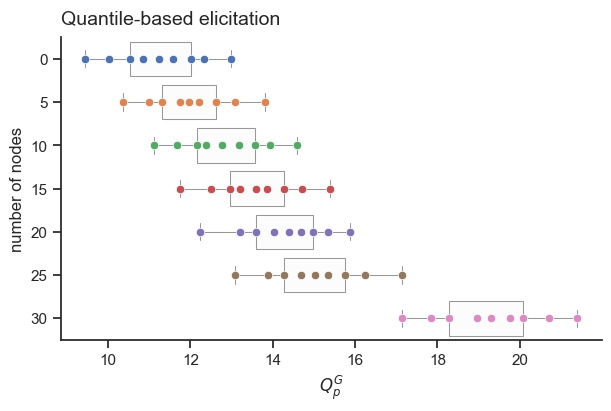

In [8]:
# plot expert predictions
plot_expert_pred(expert_res_list['y_obs_quant_0'], 
                 selected_obs = [0, 5, 10, 15, 20, 25, 30])

## Learn the prior distributions

In [9]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds", "elicits"],
                   dmatrix = dmatrix, total_count = 30)

epoch_time: 1303.419ms
Epoch: 0, loss: 3.80674, lr: 0.010000
epoch_time: 117.364ms
Epoch: 30, loss: 2.27215, lr: 0.005314
epoch_time: 107.710ms
Epoch: 60, loss: 0.92764, lr: 0.002824
epoch_time: 134.510ms
Epoch: 90, loss: 0.12320, lr: 0.001501
epoch_time: 119.300ms
Epoch: 120, loss: 0.05141, lr: 0.000798
epoch_time: 121.763ms
Epoch: 150, loss: 0.04990, lr: 0.000424
epoch_time: 126.811ms
Epoch: 180, loss: 0.04992, lr: 0.000225
epoch_time: 109.442ms
Epoch: 210, loss: 0.04916, lr: 0.000120
epoch_time: 120.821ms
Epoch: 240, loss: 0.05037, lr: 0.000100
epoch_time: 130.209ms
Epoch: 270, loss: 0.04943, lr: 0.000100


## Results

### Loss function

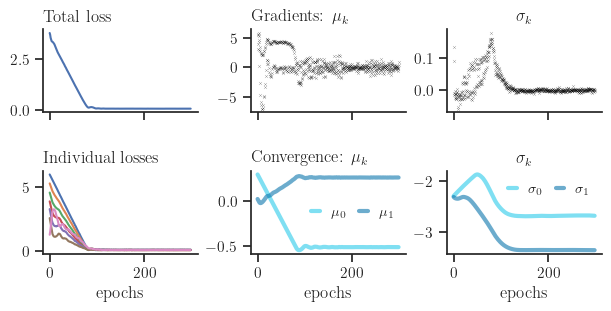

In [41]:
plot_diagnostics_binom(res_dict, user_config, save_fig = False)

### Final learned hyperparameter values

In [12]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]

tab, avg_res = _print_restab(method = "hyperparameter_learning", 
                             num_vars = 4, 
                             res = res_dict["hyperparam_info"], 
                             start = 5, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,-0.516,0.0,-0.51,0.006
scale_0,0.069,0.0,0.06,0.009
loc_1,0.261,0.0,0.26,0.001
scale_1,0.035,0.0,0.04,0.005


### Learned prior distributions

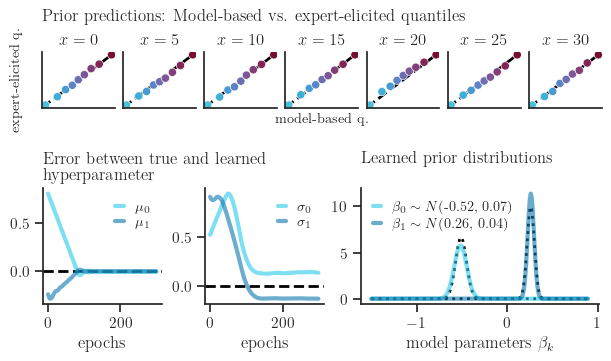

In [30]:
plot_learned_prior_binom(res_dict, user_config, true_vals, avg_res, 
                         expert_res_list, selected_obs = [0, 5, 10, 15, 20, 25, 30], 
                         save_fig = False)